In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class DynamicGraphAttention(nn.Module):
    def __init__(self, in_channels, num_nodes=32, heads=8, dropout=0.1):  # Tăng num_nodes/heads mặc định
        super().__init__()
        self.num_nodes = num_nodes
        self.heads = heads
        self.head_dim = in_channels // heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)
        self.out = nn.Linear(in_channels, in_channels)
        self.scale = nn.Parameter(torch.tensor(self.head_dim**-0.5))

        # Positional encoding (simple learnable)
        self.pos_enc = nn.Parameter(torch.randn(1, num_nodes, in_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        num_pixels = H * W
        N = min(self.num_nodes, num_pixels)
        
        # Importance sampling: Chọn top-k pixels dựa trên L2 norm (thay vì random/linspace)
        norms = torch.norm(x_flat, dim=-1)  # (B, H*W)
        _, indices = torch.topk(norms, N, dim=-1)  # Top-k indices
        indices = indices.sort(dim=-1).indices  # Sort để ổn định
        x_nodes = torch.gather(x_flat, 1, indices.unsqueeze(-1).expand(-1, -1, C))  # (B, N, C)
        
        # Thêm positional encoding
        x_nodes = x_nodes + self.pos_enc.expand(B, -1, -1)
        
        q = self.query(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.key(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.value(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Thêm dropout
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, C)
        
        out_nodes = self.out(attn_output)
        
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_(1, indices.unsqueeze(-1).expand(-1, -1, C), out_nodes)
        out = out_flat.transpose(1, 2).view(B, C, H, W)
        
        return x + out  # Residual connection

class TemporalAttentionAggregator(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads)  # Thay MLP bằng MultiheadAttention
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        if len(x.shape) == 4:  # (B, C, H, W) -> Giả sử single frame, flatten spatial
            B, C, H, W = x.size()
            x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        elif len(x.shape) == 5:  # (B, T, C, H, W) -> Flatten temporal-spatial
            B, T, C, H, W = x.size()
            x_flat = x.flatten(3).transpose(2, 3).reshape(B, T * H * W, C)  # (B, T*H*W, C)
        else:
            raise ValueError("Input must be 4D or 5D tensor")
        
        # Temporal-spatial attention
        x_flat = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_flat, x_flat, x_flat)  # Self-attention
        
        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)  # Mean pooling thay sum để ổn định
        return aggregated_vector

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=6):  # Tăng expansion mặc định
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = in_channels == out_channels and stride == 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),  # Thay ReLU6 bằng SiLU (Swish)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Thêm SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, 1),
            nn.SiLU(),
            nn.Conv2d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out * self.se(out)  # Áp dụng SE
        return x + out if self.use_residual else out

In [4]:
class PestLarvaNet_Medium(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.config = [[1, 24, 2, 1], [6, 40, 3, 2], [6, 64, 3, 2], [6, 120, 3, 2], [6, 160, 2, 1]]
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24), nn.SiLU(inplace=True))
        
        layers = []
        in_channels = 24
        for t, c, n, s in self.config:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(in_channels, c, stride, expansion=t))
                in_channels = c
            if c == 40:
                layers.append(DynamicGraphAttention(in_channels, num_nodes=32, heads=8))
        self.body = nn.Sequential(*layers)
        
        self.head_conv = nn.Conv2d(160, 384, 1, bias=False)
        self.aggregator = TemporalAttentionAggregator(384, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(384, 192), nn.SiLU(inplace=True), nn.Dropout(0.4),
            nn.Linear(192, num_classes))
            
    def forward(self, x):
        x = self.stem(x); x = self.body(x); x = self.head_conv(x)
        x = self.aggregator(x); x = self.classifier(x); return x

In [5]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [6]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path, weights_only=True)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [7]:
METADATA_PATH = r'D:\Dataset\metadata_Mel.csv' 
DATA_DIR = r'D:\Dataset\MelSpectrograms'

In [8]:
class TimeShift(torch.nn.Module):
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            # Chọn một lượng dịch chuyển ngẫu nhiên
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            # Dịch ngẫu nhiên sang trái hoặc phải
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

In [9]:
train_transform = T.Compose([
    # Kỹ thuật 1: SpecAugment (Time & Frequency Masking)
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    
    # Kỹ thuật 2: Time Shifting
    TimeShift(p=0.5, max_shift_percent=0.4),
    
    # Kỹ thuật 3: Spectrogram Noise
    SpecNoise(p=0.3, noise_level=0.03),
])

# Tập validation không sử dụng augmentation
val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [10]:
def mixup_data(x, y, alpha=0.4, use_cuda=True):
    """
    Trộn dữ liệu trong một batch.
    Trả về input đã trộn, và hai bộ nhãn gốc cùng với hệ số trộn lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Hàm tính loss đặc biệt cho Mixup.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [16]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 16
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [12]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'D:\Dataset\checkpoints_med'
LOG_CSV_PATH = r'D:\Dataset\training_log_med.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [13]:
model = PestLarvaNet_Medium(num_classes=num_classes).to(device)
total_params, _ = count_parameters(model)
print(f"Khởi tạo mô hình PestLarvaNet-GMA với {total_params/1e6:.2f}M tham số.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Khởi tạo mô hình PestLarvaNet-GMA với 1.92M tham số.


In [14]:
log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy',
    'macro_f1', 'weighted_f1', 'macro_precision', 'weighted_precision',
    'macro_recall', 'weighted_recall'
]
with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

# --- Vòng lặp huấn luyện chính ---
best_val_f1 = 0.0



Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'D:\Dataset\checkpoints_med' và log tại 'D:\Dataset\training_log_med.csv'


In [17]:
for epoch in range(EPOCHS):
    # ---------------------------
    # ----- TRAINING PHASE ------
    # ---------------------------
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for inputs, labels in progress_bar:
        if -1 in labels: continue # Bỏ qua các mẫu bị lỗi
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Áp dụng Mixup với xác suất 50%
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Chạy như bình thường nếu không dùng Mixup
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    
    accuracy = accuracy_score(val_labels, val_preds)
    macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    macro_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    macro_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
    
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # In kết quả ra màn hình
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Weighted F1: {weighted_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")

    # Lưu vào file CSV
    log_data = [
        epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy,
        macro_f1, weighted_f1, macro_precision, weighted_precision,
        macro_recall, weighted_recall
    ]
    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(log_data)
        
    # Lưu Checkpoint mỗi epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # Lưu lại model tốt nhất (dựa trên weighted F1-score)
    if weighted_f1 > best_val_f1:
        best_val_f1 = weighted_f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (Weighted F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.5599 | Val Loss: 2.0477
  Accuracy: 0.3567 | Weighted F1: 0.3629
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.3629)



Epoch 2/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.2958 | Val Loss: 0.8921
  Accuracy: 0.6805 | Weighted F1: 0.6744
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.6744)



Epoch 3/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 1.0817 | Val Loss: 1.9455
  Accuracy: 0.4129 | Weighted F1: 0.3523
  Learning Rate: 0.000999


Epoch 4/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.9609 | Val Loss: 0.6461
  Accuracy: 0.7683 | Weighted F1: 0.7613
  Learning Rate: 0.000998
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.7613)



Epoch 5/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8899 | Val Loss: 0.7425
  Accuracy: 0.7358 | Weighted F1: 0.7284
  Learning Rate: 0.000996


Epoch 6/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.8261 | Val Loss: 0.5649
  Accuracy: 0.8081 | Weighted F1: 0.8066
  Learning Rate: 0.000994
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8066)



Epoch 7/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7825 | Val Loss: 0.5536
  Accuracy: 0.8038 | Weighted F1: 0.8018
  Learning Rate: 0.000991


Epoch 8/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.7398 | Val Loss: 0.5551
  Accuracy: 0.8184 | Weighted F1: 0.8197
  Learning Rate: 0.000988
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8197)



Epoch 9/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.6987 | Val Loss: 0.4301
  Accuracy: 0.8508 | Weighted F1: 0.8467
  Learning Rate: 0.000984
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8467)



Epoch 10/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6817 | Val Loss: 0.6444
  Accuracy: 0.7908 | Weighted F1: 0.7874
  Learning Rate: 0.000980


Epoch 11/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.6515 | Val Loss: 0.4447
  Accuracy: 0.8529 | Weighted F1: 0.8504
  Learning Rate: 0.000976
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8504)



Epoch 12/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.6365 | Val Loss: 0.4920
  Accuracy: 0.8400 | Weighted F1: 0.8350
  Learning Rate: 0.000970


Epoch 13/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.6131 | Val Loss: 0.3806
  Accuracy: 0.8747 | Weighted F1: 0.8732
  Learning Rate: 0.000965
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8732)



Epoch 14/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.5937 | Val Loss: 0.4341
  Accuracy: 0.8585 | Weighted F1: 0.8578
  Learning Rate: 0.000959


Epoch 15/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.5814 | Val Loss: 0.6063
  Accuracy: 0.7972 | Weighted F1: 0.7921
  Learning Rate: 0.000952


Epoch 16/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.5663 | Val Loss: 0.5069
  Accuracy: 0.8369 | Weighted F1: 0.8324
  Learning Rate: 0.000946


Epoch 17/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.5452 | Val Loss: 0.3237
  Accuracy: 0.8933 | Weighted F1: 0.8927
  Learning Rate: 0.000938
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8927)



Epoch 18/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5444 | Val Loss: 0.3180
  Accuracy: 0.8963 | Weighted F1: 0.8966
  Learning Rate: 0.000930
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.8966)



Epoch 19/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.5274 | Val Loss: 2.1190
  Accuracy: 0.5384 | Weighted F1: 0.5349
  Learning Rate: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.5222 | Val Loss: 1.2236
  Accuracy: 0.6747 | Weighted F1: 0.6609
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.5112 | Val Loss: 0.3873
  Accuracy: 0.8761 | Weighted F1: 0.8782
  Learning Rate: 0.000905


Epoch 22/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.5006 | Val Loss: 0.9908
  Accuracy: 0.6863 | Weighted F1: 0.6707
  Learning Rate: 0.000895


Epoch 23/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.4789 | Val Loss: 0.5771
  Accuracy: 0.8233 | Weighted F1: 0.8191
  Learning Rate: 0.000885


Epoch 24/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.4733 | Val Loss: 0.2756
  Accuracy: 0.9105 | Weighted F1: 0.9103
  Learning Rate: 0.000875
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9103)



Epoch 25/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.4685 | Val Loss: 0.4424
  Accuracy: 0.8554 | Weighted F1: 0.8509
  Learning Rate: 0.000864


Epoch 26/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.4550 | Val Loss: 1.5417
  Accuracy: 0.6013 | Weighted F1: 0.5759
  Learning Rate: 0.000854


Epoch 27/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.4520 | Val Loss: 0.2763
  Accuracy: 0.9082 | Weighted F1: 0.9078
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.4472 | Val Loss: 0.3879
  Accuracy: 0.8817 | Weighted F1: 0.8804
  Learning Rate: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.4435 | Val Loss: 1.6267
  Accuracy: 0.6328 | Weighted F1: 0.6087
  Learning Rate: 0.000819


Epoch 30/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.4257 | Val Loss: 0.4775
  Accuracy: 0.8500 | Weighted F1: 0.8521
  Learning Rate: 0.000806


Epoch 31/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4190 | Val Loss: 0.3729
  Accuracy: 0.8887 | Weighted F1: 0.8880
  Learning Rate: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.4157 | Val Loss: 4.2916
  Accuracy: 0.2970 | Weighted F1: 0.2783
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.4133 | Val Loss: 0.3748
  Accuracy: 0.8911 | Weighted F1: 0.8918
  Learning Rate: 0.000768


Epoch 34/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.4023 | Val Loss: 0.3936
  Accuracy: 0.8818 | Weighted F1: 0.8802
  Learning Rate: 0.000755


Epoch 35/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.3887 | Val Loss: 0.6028
  Accuracy: 0.8418 | Weighted F1: 0.8404
  Learning Rate: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3870 | Val Loss: 0.3170
  Accuracy: 0.9088 | Weighted F1: 0.9083
  Learning Rate: 0.000727


Epoch 37/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3746 | Val Loss: 0.2955
  Accuracy: 0.9137 | Weighted F1: 0.9132
  Learning Rate: 0.000713
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9132)



Epoch 38/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3849 | Val Loss: 0.2918
  Accuracy: 0.9128 | Weighted F1: 0.9125
  Learning Rate: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3688 | Val Loss: 0.4397
  Accuracy: 0.8788 | Weighted F1: 0.8777
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3728 | Val Loss: 0.3034
  Accuracy: 0.9075 | Weighted F1: 0.9068
  Learning Rate: 0.000669


Epoch 41/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3637 | Val Loss: 2.5573
  Accuracy: 0.5080 | Weighted F1: 0.4688
  Learning Rate: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3610 | Val Loss: 0.3699
  Accuracy: 0.8987 | Weighted F1: 0.8971
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3612 | Val Loss: 0.3763
  Accuracy: 0.8978 | Weighted F1: 0.8968
  Learning Rate: 0.000624


Epoch 44/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3530 | Val Loss: 0.3258
  Accuracy: 0.9148 | Weighted F1: 0.9141
  Learning Rate: 0.000609
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9141)



Epoch 45/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3457 | Val Loss: 0.3570
  Accuracy: 0.9057 | Weighted F1: 0.9046
  Learning Rate: 0.000594


Epoch 46/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3486 | Val Loss: 0.4746
  Accuracy: 0.8705 | Weighted F1: 0.8685
  Learning Rate: 0.000578


Epoch 47/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3249 | Val Loss: 0.3734
  Accuracy: 0.8999 | Weighted F1: 0.8999
  Learning Rate: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3327 | Val Loss: 0.3125
  Accuracy: 0.9151 | Weighted F1: 0.9148
  Learning Rate: 0.000547
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9148)



Epoch 49/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3223 | Val Loss: 0.3914
  Accuracy: 0.8973 | Weighted F1: 0.8961
  Learning Rate: 0.000531


Epoch 50/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3294 | Val Loss: 0.3229
  Accuracy: 0.9144 | Weighted F1: 0.9137
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3214 | Val Loss: 0.3165
  Accuracy: 0.9123 | Weighted F1: 0.9118
  Learning Rate: 0.000500


Epoch 52/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3316 | Val Loss: 0.3264
  Accuracy: 0.9183 | Weighted F1: 0.9182
  Learning Rate: 0.000484
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9182)



Epoch 53/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3263 | Val Loss: 0.3582
  Accuracy: 0.9178 | Weighted F1: 0.9178
  Learning Rate: 0.000469


Epoch 54/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3220 | Val Loss: 0.3661
  Accuracy: 0.9096 | Weighted F1: 0.9089
  Learning Rate: 0.000453


Epoch 55/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3200 | Val Loss: 0.3742
  Accuracy: 0.9160 | Weighted F1: 0.9156
  Learning Rate: 0.000437


Epoch 56/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3165 | Val Loss: 3.0618
  Accuracy: 0.4280 | Weighted F1: 0.4041
  Learning Rate: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3218 | Val Loss: 0.3406
  Accuracy: 0.9159 | Weighted F1: 0.9160
  Learning Rate: 0.000406


Epoch 58/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3210 | Val Loss: 0.3412
  Accuracy: 0.9206 | Weighted F1: 0.9201
  Learning Rate: 0.000391
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9201)



Epoch 59/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3117 | Val Loss: 0.3426
  Accuracy: 0.9135 | Weighted F1: 0.9134
  Learning Rate: 0.000376


Epoch 60/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3100 | Val Loss: 0.3390
  Accuracy: 0.9210 | Weighted F1: 0.9209
  Learning Rate: 0.000361
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9209)



Epoch 61/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.2999 | Val Loss: 0.3199
  Accuracy: 0.9221 | Weighted F1: 0.9219
  Learning Rate: 0.000345
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9219)



Epoch 62/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.2978 | Val Loss: 0.3492
  Accuracy: 0.9201 | Weighted F1: 0.9198
  Learning Rate: 0.000331


Epoch 63/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3132 | Val Loss: 0.3814
  Accuracy: 0.9163 | Weighted F1: 0.9159
  Learning Rate: 0.000316


Epoch 64/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.2968 | Val Loss: 0.5049
  Accuracy: 0.8811 | Weighted F1: 0.8796
  Learning Rate: 0.000301


Epoch 65/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.2914 | Val Loss: 0.3554
  Accuracy: 0.9178 | Weighted F1: 0.9169
  Learning Rate: 0.000287


Epoch 66/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.2917 | Val Loss: 0.3481
  Accuracy: 0.9215 | Weighted F1: 0.9215
  Learning Rate: 0.000273


Epoch 67/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3007 | Val Loss: 0.3454
  Accuracy: 0.9216 | Weighted F1: 0.9212
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.2921 | Val Loss: 0.3160
  Accuracy: 0.9211 | Weighted F1: 0.9211
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.2844 | Val Loss: 0.3859
  Accuracy: 0.9188 | Weighted F1: 0.9186
  Learning Rate: 0.000232


Epoch 70/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.2912 | Val Loss: 0.3441
  Accuracy: 0.9207 | Weighted F1: 0.9199
  Learning Rate: 0.000219


Epoch 71/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.2872 | Val Loss: 0.3523
  Accuracy: 0.9245 | Weighted F1: 0.9245
  Learning Rate: 0.000206
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9245)



Epoch 72/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.2864 | Val Loss: 0.3362
  Accuracy: 0.9250 | Weighted F1: 0.9248
  Learning Rate: 0.000194
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9248)



Epoch 73/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.2890 | Val Loss: 4.7811
  Accuracy: 0.1733 | Weighted F1: 0.1727
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.2798 | Val Loss: 6.2551
  Accuracy: 0.1086 | Weighted F1: 0.1064
  Learning Rate: 0.000169


Epoch 75/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.2872 | Val Loss: 0.3584
  Accuracy: 0.9224 | Weighted F1: 0.9221
  Learning Rate: 0.000158


Epoch 76/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2874 | Val Loss: 0.3585
  Accuracy: 0.9238 | Weighted F1: 0.9234
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.2912 | Val Loss: 0.3861
  Accuracy: 0.9246 | Weighted F1: 0.9243
  Learning Rate: 0.000136


Epoch 78/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.2786 | Val Loss: 0.3661
  Accuracy: 0.9227 | Weighted F1: 0.9222
  Learning Rate: 0.000125


Epoch 79/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2861 | Val Loss: 0.3277
  Accuracy: 0.9249 | Weighted F1: 0.9248
  Learning Rate: 0.000115


Epoch 80/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2775 | Val Loss: 0.3964
  Accuracy: 0.9211 | Weighted F1: 0.9204
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.2828 | Val Loss: 0.3954
  Accuracy: 0.9253 | Weighted F1: 0.9251
  Learning Rate: 0.000095
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9251)



Epoch 82/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2803 | Val Loss: 0.3483
  Accuracy: 0.9247 | Weighted F1: 0.9244
  Learning Rate: 0.000086


Epoch 83/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.2802 | Val Loss: 0.3782
  Accuracy: 0.9256 | Weighted F1: 0.9252
  Learning Rate: 0.000078
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9252)



Epoch 84/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2776 | Val Loss: 0.3633
  Accuracy: 0.9256 | Weighted F1: 0.9252
  Learning Rate: 0.000070


Epoch 85/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2878 | Val Loss: 2.4033
  Accuracy: 0.6037 | Weighted F1: 0.6062
  Learning Rate: 0.000062


Epoch 86/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2754 | Val Loss: 0.3728
  Accuracy: 0.9256 | Weighted F1: 0.9252
  Learning Rate: 0.000054
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9252)



Epoch 87/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.2781 | Val Loss: 0.4222
  Accuracy: 0.9253 | Weighted F1: 0.9251
  Learning Rate: 0.000048


Epoch 88/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2848 | Val Loss: 7.4084
  Accuracy: 0.1542 | Weighted F1: 0.1819
  Learning Rate: 0.000041


Epoch 89/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2791 | Val Loss: 0.3887
  Accuracy: 0.9234 | Weighted F1: 0.9230
  Learning Rate: 0.000035


Epoch 90/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2816 | Val Loss: 0.3998
  Accuracy: 0.9255 | Weighted F1: 0.9253
  Learning Rate: 0.000030
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9253)



Epoch 91/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.2844 | Val Loss: 0.3522
  Accuracy: 0.9254 | Weighted F1: 0.9254
  Learning Rate: 0.000024
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9254)



Epoch 92/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2731 | Val Loss: 0.3876
  Accuracy: 0.9207 | Weighted F1: 0.9203
  Learning Rate: 0.000020


Epoch 93/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2723 | Val Loss: 0.3790
  Accuracy: 0.9235 | Weighted F1: 0.9236
  Learning Rate: 0.000016


Epoch 94/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.2674 | Val Loss: 0.3558
  Accuracy: 0.9268 | Weighted F1: 0.9265
  Learning Rate: 0.000012
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9265)



Epoch 95/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2715 | Val Loss: 0.4163
  Accuracy: 0.9159 | Weighted F1: 0.9154
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2730 | Val Loss: 0.3890
  Accuracy: 0.9255 | Weighted F1: 0.9252
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2738 | Val Loss: 0.3362
  Accuracy: 0.9251 | Weighted F1: 0.9249
  Learning Rate: 0.000004


Epoch 98/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2730 | Val Loss: 0.3457
  Accuracy: 0.9252 | Weighted F1: 0.9252
  Learning Rate: 0.000002


Epoch 99/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2738 | Val Loss: 0.3512
  Accuracy: 0.9272 | Weighted F1: 0.9270
  Learning Rate: 0.000001
  => 🎉 New best model saved to 'D:\Dataset\checkpoints_med\best_model.pth' (Weighted F1: 0.9270)



Epoch 100/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2667 | Val Loss: 0.3738
  Accuracy: 0.9254 | Weighted F1: 0.9250
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


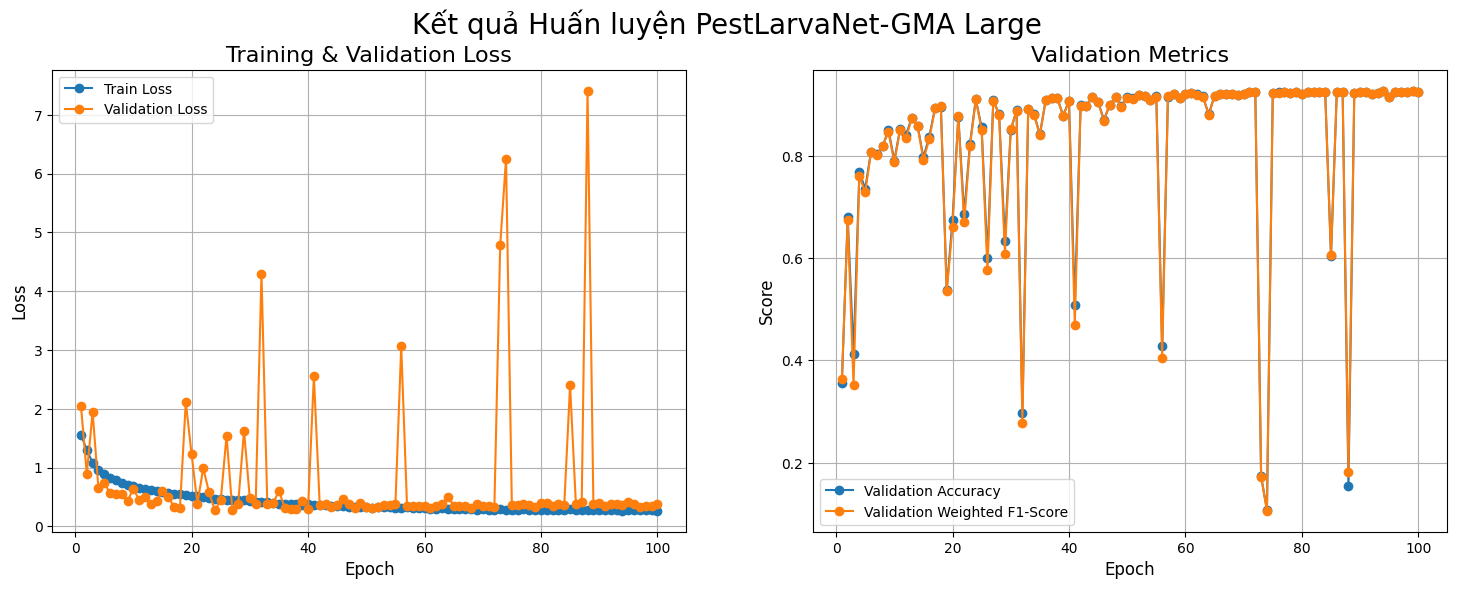

C:\Users\Deltax\AppData\Local\Temp\ipykernel_4272\1807958012.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locat


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


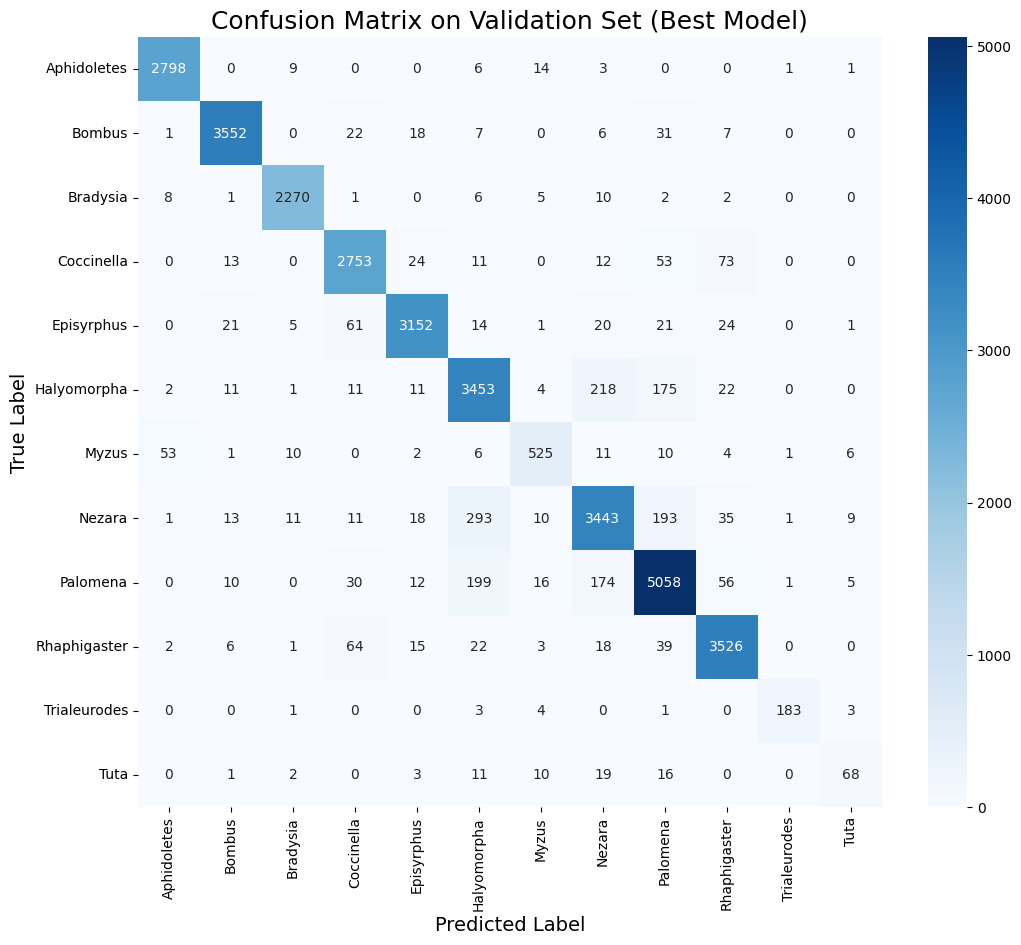

In [18]:
log_df = pd.read_csv(LOG_CSV_PATH)

# --- Vẽ biểu đồ Loss và Accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Validation Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['weighted_f1'], label='Validation Weighted F1-Score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện PestLarvaNet-GMA Large', fontsize=20)
plt.show()

# --- Vẽ Ma trận nhầm lẫn (Confusion Matrix) ---
# Tải lại trọng số của model tốt nhất để đánh giá
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")
    
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.class_names, 
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()